In [1]:
import os
import csv
import time
import copy
import random
from collections import Counter, defaultdict
from heapq import nlargest

import numpy as np
import pandas as pd
from scipy import stats
import scipy.sparse.linalg as linalg
import powerlaw

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns

# Network analysis
import networkx as nx
from networkx.algorithms.community import (
    greedy_modularity_communities,
    label_propagation_communities,
    modularity,
    partition_quality
)

import community as community_louvain

In [2]:
# Reproducibility
SEED = 69069


random.seed(SEED)           # For basic Python random
np.random.seed(SEED)        # For NumPy (Null models, stats)
os.environ['PYTHONHASHSEED'] = str(SEED) # For dictionary/set consistency

# Styling Settings
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 22,
    "font.size": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.spines.top": False,    
    "axes.spines.right": False,  
    "pdf.fonttype": 42,      
    "ps.fonttype": 42,
})

In [3]:
# Load data (store weights we will not use them)
G_raw = nx.Graph()

data_filename = "data/ingredients_network.csv"

with open(data_filename, newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0].startswith("#"):
            continue
        ing1, ing2, weight = row
        G_raw.add_edge(ing1, ing2, weight=int(weight))

print("Raw network:")
print("Nodes:", G_raw.number_of_nodes())
print("Edges:", G_raw.number_of_edges())

# Compute degrees
degrees_raw = np.array([deg for node, deg in G_raw.degree()])
mean_degree_raw = np.mean(degrees_raw)
std_degree_raw = np.std(degrees_raw)

print("Mean degree:", mean_degree_raw)
print("Standard deviation of degrees:", std_degree_raw)

Raw network:
Nodes: 1507
Edges: 221777
Mean degree: 294.3291307232913
Standard deviation of degrees: 285.74924709803594


In [4]:
# Find Largest connected component
if not nx.is_connected(G_raw):
    largest_cc = max(nx.connected_components(G_raw), key=len)
    G = G_raw.subgraph(largest_cc).copy()
else:
    G = G_raw.copy()

print("\nLargest connected component:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Largest connected component:
Nodes: 1496
Edges: 221754


In [5]:
N = G.number_of_nodes()
E = G.number_of_edges()
density = nx.density(G)

print("\nBasic descriptors:")
print(f"N = {N}")
print(f"E = {E}")
print(f"Density = {density:.6f}")
# Compute degrees
degrees = np.array([deg for node, deg in G.degree()])
mean_degree = np.mean(degrees)
std_degree = np.std(degrees)

print("Mean degree:", mean_degree)
print("Standard deviation of degrees:", std_degree)




Basic descriptors:
N = 1496
E = 221754
Density = 0.198303
Mean degree: 296.46256684491976
Standard deviation of degrees: 285.7086179557067


In [6]:
components = list(nx.connected_components(G_raw))
components_sorted = sorted(components, key=len, reverse=True)

non_lcc_components = components_sorted[1:]

print("Number of connected components:", len(components))
print("Number of nodes outside LCC:", sum(len(c) for c in non_lcc_components))

Number of connected components: 4
Number of nodes outside LCC: 11


## Nodes outside largest component

In [7]:
G_small = G_raw.subgraph(
    set().union(*[c for c in non_lcc_components if len(c) <= 10])
)

C:\Users\aleix\AppData\Local\Temp\ipykernel_33052\3826602109.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


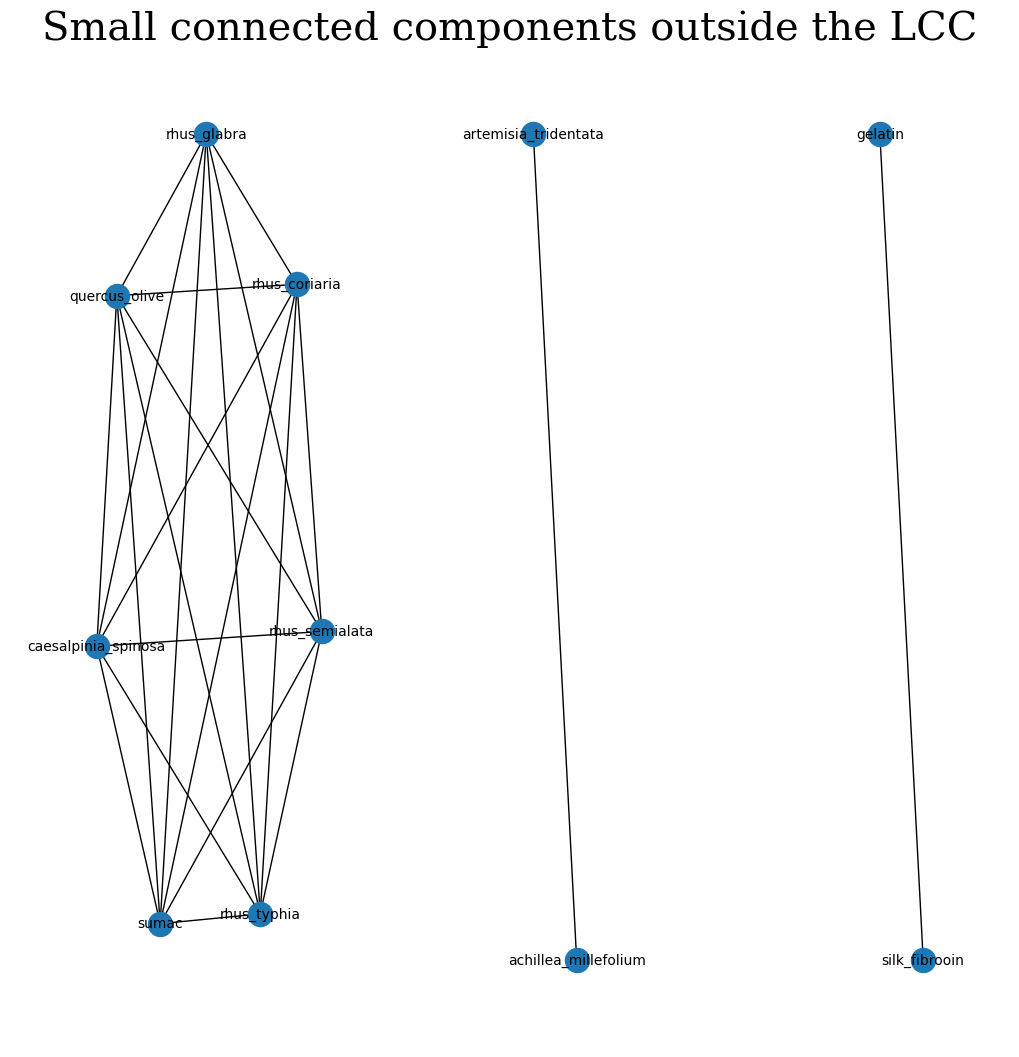

In [8]:
plt.figure(figsize=(10, 10))

pos = {}
x_offset = 0

for comp in nx.connected_components(G_small):
    sub = G_small.subgraph(comp)
    
    sub_pos = nx.spring_layout(
        sub,
        seed=SEED,
        k=1.5,
        iterations=200
    )
    
    # shift each component horizontally
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + x_offset, y)
    
    x_offset += 3  # space between components

nx.draw(
    G_small,
    pos,
    node_size=300,
    with_labels=True,
    font_size=10
)

plt.title("Small connected components outside the LCC")
plt.axis("off")
plt.tight_layout()
plt.show()


# Basic Descriptors

In [9]:
N = G.number_of_nodes()
E = G.number_of_edges()
density = nx.density(G)

print("\nBasic descriptors:")
print(f"N = {N}")
print(f"E = {E}")
print(f"Density = {density:.6f}")
# Compute degrees
degrees = np.array([deg for node, deg in G.degree()])
mean_degree = np.mean(degrees)
std_degree = np.std(degrees)

print("Mean degree:", mean_degree)
print("Standard deviation of degrees:", std_degree)


Basic descriptors:
N = 1496
E = 221754
Density = 0.198303
Mean degree: 296.46256684491976
Standard deviation of degrees: 285.7086179557067


# Degree statstics and fitting

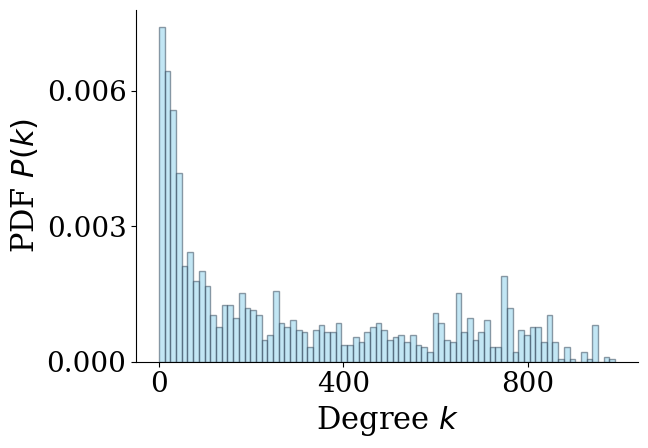

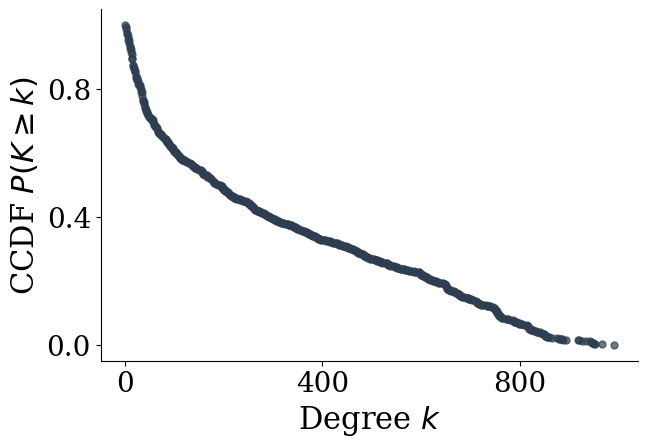

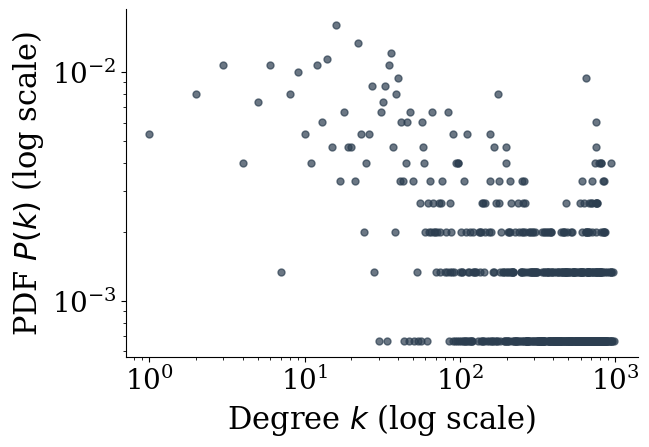

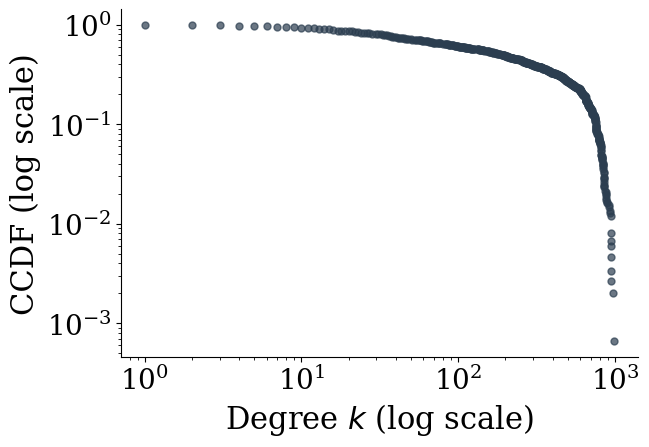

In [10]:
# PDF
degree_counts = Counter(degrees)
k_vals = np.array(sorted(degree_counts.keys()))
pdf = np.array([degree_counts[k] for k in k_vals]) / N

# CCDF
ccdf = np.array([np.sum(degrees >= k) / N for k in k_vals])

def apply_ticks(ax, x_log=False, y_log=False):
    """Utility to limit ticks to 3-4 and handle log scales."""
    if x_log:
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    else:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
        
    if y_log:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    else:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

# Plot Parameters
color_main = '#2c3e50'
marker_style = 'o'
alpha_val = 0.7

# 1. Degree PDF (Linear Histogram)
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(degrees, bins=80, density=True, alpha=0.5, color='skyblue', edgecolor=color_main)
ax.set_xlabel(r"Degree $k$")
ax.set_ylabel(r"PDF $P(k)$")
apply_ticks(ax)
plt.tight_layout()
plt.savefig("degree_pdf_hist_linear.pdf", bbox_inches="tight")

# 2. Degree CCDF (Linear)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(k_vals, ccdf, marker_style, color=color_main, markersize=5, alpha=alpha_val, linestyle='none')
ax.set_xlabel(r"Degree $k$")
ax.set_ylabel(r"CCDF $P(K \geq k)$")
apply_ticks(ax)
plt.tight_layout()
plt.savefig("degree_ccdf_linear.pdf", bbox_inches="tight")

# 3. Degree PDF (Log-Log)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(k_vals, pdf, marker_style, color=color_main, markersize=5, alpha=alpha_val, linestyle='none')
ax.set_xlabel(r"Degree $k$ (log scale)")
ax.set_ylabel(r"PDF $P(k)$ (log scale)")
apply_ticks(ax, x_log=True, y_log=True)
plt.tight_layout()
plt.savefig("degree_pdf_loglog.pdf", bbox_inches="tight")

# 4. Degree CCDF (Log-Log)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(k_vals, ccdf, marker_style, color=color_main, markersize=5, alpha=alpha_val, linestyle='none')
ax.set_xlabel(r"Degree $k$ (log scale)")
ax.set_ylabel(r"CCDF (log scale)")
apply_ticks(ax, x_log=True, y_log=True)
plt.tight_layout()
plt.savefig("degree_ccdf_loglog.pdf", bbox_inches="tight")

In [11]:
# Helper function to compute AIC and BIC
def calculate_aic_bic(log_lik, n_params, n_obs):
    aic = 2 * n_params - 2 * log_lik
    bic = n_params * np.log(n_obs) - 2 * log_lik
    return aic, bic

# Fitting function
def perform_analysis(degrees):
    degrees = np.array(degrees)
    N = len(degrees)
    results = []

    # Power Law (discrete, powerlaw package)
    fit_pl = powerlaw.Fit(degrees, discrete=True, verbose=False)
    results.append({
        'Distribution': 'Power Law',
        'Parameters': f"alpha={fit_pl.alpha:.3f}, xmin={fit_pl.xmin}",
        'KS Statistic': fit_pl.D,
        'fit_instance': fit_pl,
        'AIC': np.nan,
        'BIC': np.nan,
        'dist_obj': fit_pl.power_law,
        'is_powerlaw': True
    })

    # Other continuous distributions, the numbers represent the number of parameters the distribution has.
    candidates = [
        ('lognorm', 3, 'Log-Normal', ['s', 'loc', 'scale']),
        ('expon', 2, 'Exponential', ['loc', 'scale']),
        ('exponnorm', 3, 'EMG', ['K', 'loc', 'scale']),
        ('mielke', 4, 'Dagum (Mielke)', ['k', 's', 'loc', 'scale'])
    ]

    for dist_name, n_params, label, param_names in candidates:
        dist = getattr(stats, dist_name)
        params = dist.fit(degrees)
        dist_obj = dist(*params)

        # Compute log-likelihood
        log_lik = np.sum(dist_obj.logpdf(degrees))
        
        ks = stats.kstest(degrees, lambda x: dist_obj.cdf(x)).statistic

        # AIC and BIC
        aic, bic = calculate_aic_bic(log_lik, n_params, N)

        params_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, params)])

        results.append({
            'Distribution': label,
            'Parameters': params_str,
            'KS Statistic': ks,
            'AIC': aic,
            'BIC': bic,
            'dist_obj': dist_obj,
            'is_powerlaw': False
        })

    return results


In [12]:
# SETUP DATA
degrees = np.array(degrees)

sorted_degrees = np.sort(degrees)
y_ccdf = 1.0 - np.arange(1, N + 1) / N

x_space = np.logspace(
    np.log10(max(1, degrees.min())),
    np.log10(degrees.max()),
    1000
)

results_fit = perform_analysis(degrees)

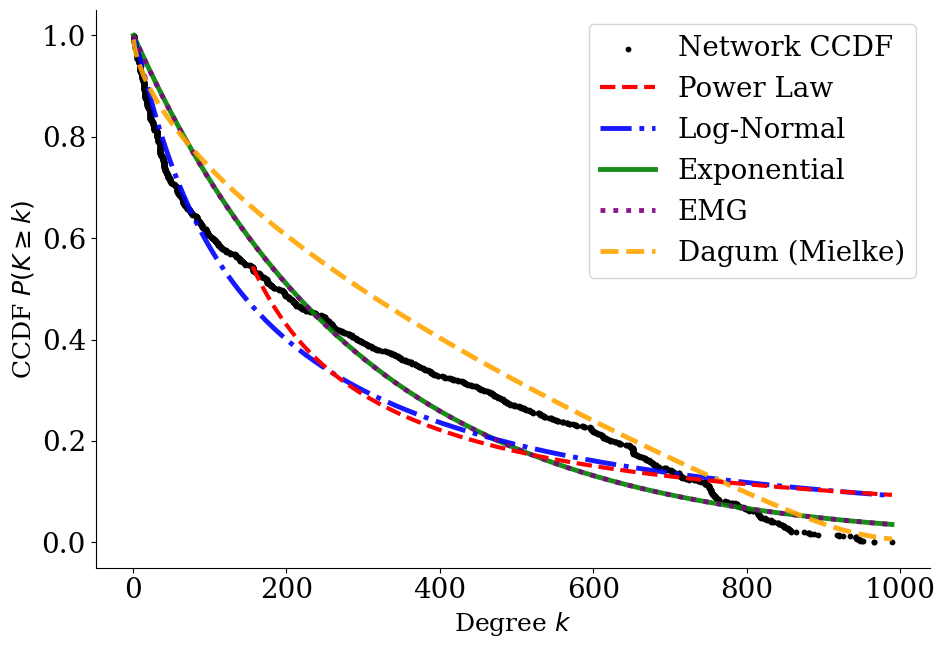

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))


# Network CCDF as scatter
ax.scatter(
    sorted_degrees,
    y_ccdf,
    color='black',
    s=10,
    label='Network CCDF',
    zorder=0
)

# Color mapping
style_map = {
    'Power Law':          dict(color='red',    linestyle='--', zorder=6),
    'Log-Normal':         dict(color='blue',   linestyle='-.', zorder=7),
    'Exponential':        dict(color='green',  linestyle='-',  zorder=5),
    'EMG':                dict(color='purple',  linestyle=':',  zorder=8),
    'Dagum (Mielke)':     dict(color='orange', linestyle='--', zorder=9)
}

# Theoretical Model CCDFs
for r in results_fit:
    name = r['Distribution']

    if r['is_powerlaw']:
        fit = r['fit_instance']
    
        # Degrees in the tail only
        fit_x = np.unique(degrees)
        fit_x = fit_x[fit_x >= fit.xmin]
    
        # Conditional CCDF from the model
        fit_y = fit.power_law.ccdf(fit_x)
    
        tail_ratio = np.sum(degrees >= fit.xmin) / len(degrees)
        fit_y_scaled = fit_y * tail_ratio
    
        ax.plot(
            fit_x,
            fit_y_scaled,
            color='red',
            linestyle='--',
            lw=3,
            label=rf"Power Law",
            zorder=20
        )

    else:
        style = style_map.get(name, dict(color='gray', linestyle='-', zorder=5))
        ax.plot(
            x_space,
            1.0 - r['dist_obj'].cdf(x_space),
            lw=3.5,
            alpha=0.9,
            label=name,
            **style
        )

ax.set_xlabel(r"Degree $k$", fontsize=18)
ax.set_ylabel(r"CCDF $P(K \geq k)$", fontsize=18)

ax.legend(fontsize=20)
ax.grid(False)

plt.tight_layout()

plt.show()

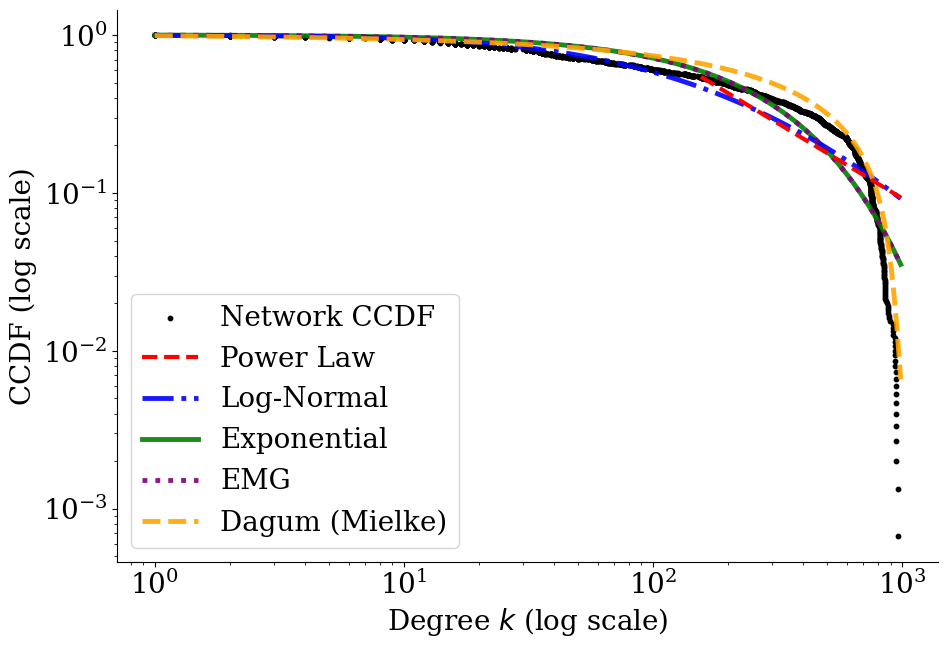

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

# Network CCDF as scatter
ax.scatter(
    sorted_degrees,
    y_ccdf,
    color='black',
    s=10,
    label='Network CCDF',
    zorder=0
)

# Color mapping
style_map = {
    'Power Law':          dict(color='red',    linestyle='--', zorder=6),
    'Log-Normal':         dict(color='blue',   linestyle='-.', zorder=7),
    'Exponential':        dict(color='green',  linestyle='-',  zorder=5),
    'EMG':                dict(color='purple',  linestyle=':',  zorder=8),
    'Dagum (Mielke)':     dict(color='orange', linestyle='--', zorder=9)
}

# Theoretical Model CCDFs
for r in results_fit:
    name = r['Distribution']

    if r['is_powerlaw']:
        fit = r['fit_instance']
    
        # Degrees in the tail only
        fit_x = np.unique(degrees)
        fit_x = fit_x[fit_x >= fit.xmin]
    
        # Conditional CCDF from the model
        fit_y = fit.power_law.ccdf(fit_x)
    
        tail_ratio = np.sum(degrees >= fit.xmin) / len(degrees)
        fit_y_scaled = fit_y * tail_ratio
    
        ax.plot(
            fit_x,
            fit_y_scaled,
            color='red',
            linestyle='--',
            lw=3,
            label=rf"Power Law",
            zorder=20
        )

    else:
        style = style_map.get(name, dict(color='gray', linestyle='-', zorder=5))
        ax.plot(
            x_space,
            1.0 - r['dist_obj'].cdf(x_space),
            lw=3.5,
            alpha=0.9,
            label=name,
            **style
        )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Degree $k$ (log scale)", fontsize=20)
ax.set_ylabel(r"CCDF (log scale)", fontsize=20)

ax.legend(fontsize=20)
ax.grid(False)

plt.tight_layout()
plt.savefig("ccdf_fits_scatter.pdf", bbox_inches="tight")
plt.show()

## Goodness of fit

In [15]:
# Summary table
df = pd.DataFrame(results_fit)
df = df[['Distribution', 'Parameters', 'KS Statistic', 'AIC', 'BIC']]
df = df.sort_values('KS Statistic')

print("\nSummary table (lower KS = better fit):\n")
print(df.to_string(index=False))



Summary table (lower KS = better fit):

  Distribution                                  Parameters  KS Statistic          AIC          BIC
    Log-Normal          s=1.480, loc=-2.051, scale=138.999      0.101420 20187.896237 20203.827888
Dagum (Mielke) k=0.596, s=26.616, loc=0.704, scale=949.438      0.137133 19683.869355 19705.111556
           EMG          K=1947.248, loc=0.717, scale=0.152      0.140166 20021.489539 20037.421189
   Exponential                    loc=1.000, scale=295.463      0.141036 20016.118117 20026.739218
     Power Law                     alpha=1.951, xmin=156.0      0.207262          NaN          NaN


# Clustering and Distances

In [16]:
start_time = time.time()

# Compute average clustering
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient = {avg_clustering:.4f}")

end_time = time.time()
elapsed = end_time - start_time
print(f"Time taken: {elapsed:.2f} seconds")

Average clustering coefficient = 0.8581
Time taken: 66.22 seconds


In [17]:
# Distances
start_time = time.time()

avg_path_length = nx.average_shortest_path_length(G)

diameter = nx.diameter(G)

# Effective diameter: 90th percentile of shortest-path lengths
lengths = []
for source, dist_dict in nx.all_pairs_shortest_path_length(G):
    for target, dist in dist_dict.items():
        if source != target:
            lengths.append(dist)

effective_diameter = np.percentile(lengths, 90)


print("\nDistances:")
print(f"Average shortest path length = {avg_path_length:.4f}")
print(f"Diameter = {diameter:.3f}")
print(f"Effective diameter (90%) = {effective_diameter:.3f}")

end_time = time.time()
elapsed = end_time - start_time
print(f"Time taken: {elapsed:.2f} seconds")


Distances:
Average shortest path length = 1.9205
Diameter = 4.000
Effective diameter (90%) = 3.000
Time taken: 458.25 seconds


# Centrality measures

In [18]:
# Preparations for Katz centrality:
adj_matrix = nx.to_scipy_sparse_array(G, dtype=float)

# Calculate the largest eigenvalue
eigenvalues = linalg.eigsh(adj_matrix, k=1, which='LM', return_eigenvectors=False)
lambda_max = eigenvalues[0]

# Set alpha safely below 1/lambda_max
safe_alpha = 0.5 / lambda_max 

print(f"λ_max: {lambda_max:.4f}")
print(f"Set alpha below the Convergence Limit (1/λ_max): {1/lambda_max:.6f}")
print(f"Using alpha: {safe_alpha:.6f}")

λ_max: 11334.7789
Set alpha below the Convergence Limit (1/λ_max): 0.000088
Using alpha: 0.000044


In [19]:
centralities = {}
timings = {}

# Degree centrality
start = time.time()
centralities["degree"] = dict(G.degree())
timings["degree"] = time.time() - start

# Closeness centrality
start = time.time()
centralities["closeness"] = nx.closeness_centrality(G)
timings["closeness"] = time.time() - start

# Betweenness centrality
start = time.time()
centralities["betweenness"] = nx.betweenness_centrality(G)
timings["betweenness"] = time.time() - start

# Eigenvector centrality
start = time.time()
centralities["eigenvector"] = nx.eigenvector_centrality_numpy(G)
timings["eigenvector"] = time.time() - start

# Katz centrality
start = time.time()
centralities["katz"] = nx.katz_centrality_numpy(G, alpha=safe_alpha, beta=1.0)
timings["katz"] = time.time() - start

# PageRank
start = time.time()
centralities["pagerank"] = nx.pagerank(G)
timings["pagerank"] = time.time() - start

# Subgraph centrality
start = time.time()
centralities["subgraph"] = nx.subgraph_centrality(G)
timings["subgraph"] = time.time() - start

In [20]:
# Create a dictionary to store ordered top-25 lists
top25_nodes = {}

for name, cent in centralities.items():
    # Sort and take top 25
    top25 = nlargest(25, cent.items(), key=lambda x: x[1])
    
    # Keep only node names, in order
    top25_nodes[name] = [node for node, _ in top25]

# Build ranking index (1st to 25th)
rank_index = [f"{i}." for i in range(1, 26)]

top25_df = pd.DataFrame(top25_nodes, index=rank_index)

top25_df

,degree,closeness,betweenness,eigenvector,katz,pagerank,subgraph
1.,black_tea,black_tea,black_tea,black_tea,black_tea,black_tea,black_tea
2.,green_tea,green_tea,ginger,roasted_green_tea,green_tea,roasted_green_tea,green_tea
3.,roasted_green_tea,roasted_green_tea,french_lavender,green_tea,roasted_green_tea,green_tea,roasted_green_tea
4.,bantu_beer,bantu_beer,raspberry,fermented_tea,bantu_beer,bantu_beer,fermented_tea
5.,fermented_tea,fermented_tea,israeli_orange,rooibus_tea,fermented_tea,beer,rooibus_tea
6.,beer,beer,coriander,ceylon_tea,rooibus_tea,fermented_tea,ceylon_tea
7.,rooibus_tea,rooibus_tea,orange,seychelles_tea,beer,rooibus_tea,seychelles_tea
8.,ceylon_tea,strawberry,california_orange,dried_black_tea,seychelles_tea,strawberry,dried_green_tea
9.,seychelles_tea,ceylon_tea,cinnamon,dried_green_tea,ceylon_tea,roasted_beef,dried_black_tea
10.,strawberry,seychelles_tea,vanilla,tea,strawberry,ceylon_tea,kola_tea


In [21]:
# Print time taken for each centrality
print("\nTime taken per centrality (seconds):")
for name, t in timings.items():
    print(f"{name:12s}: {t:.2f}")


Time taken per centrality (seconds):
degree      : 0.00
closeness   : 151.87
betweenness : 284.39
eigenvector : 0.68
katz        : 0.73
pagerank    : 0.60
subgraph    : 1.27


## Centrality score and centrality rankings

In [22]:
# Compute combined centrality score based on 1/rank
centrality_scores = defaultdict(float)

for cname, cent_dict in centralities.items():
    # Sort descending by centrality value and take top 25
    top25 = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:25]
    
    # Assign 1/rank to each node
    for rank, (node, value) in enumerate(top25, start=1):
        centrality_scores[node] += 1.0 / rank

print("\nCombined Centrality Scores:")
for node, score in sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{node:25s} {score:.4f}")


Combined Centrality Scores:
black_tea                 7.0000
green_tea                 2.7143
roasted_green_tea         2.3788
fermented_tea             1.2667
bantu_beer                1.2083
rooibus_tea               0.9952
beer                      0.8584
ceylon_tea                0.7806
seychelles_tea            0.7127
strawberry                0.6391
dried_black_tea           0.5922
dried_green_tea           0.5630
ginger                    0.5000
raspberry                 0.4846
kola_tea                  0.4661
tea                       0.4423
pouching_tea              0.4198
jasmine_tea               0.4155
fermented_russian_black_tea 0.3861
white_wine                0.3791
brewed_tea                0.3706
israeli_orange            0.3500
french_lavender           0.3333
orange                    0.2814
california_orange         0.2616
parmesan_cheese           0.2594
gruyere_cheese            0.2152
coriander                 0.1667
cinnamon                  0.1111
roasted_beef

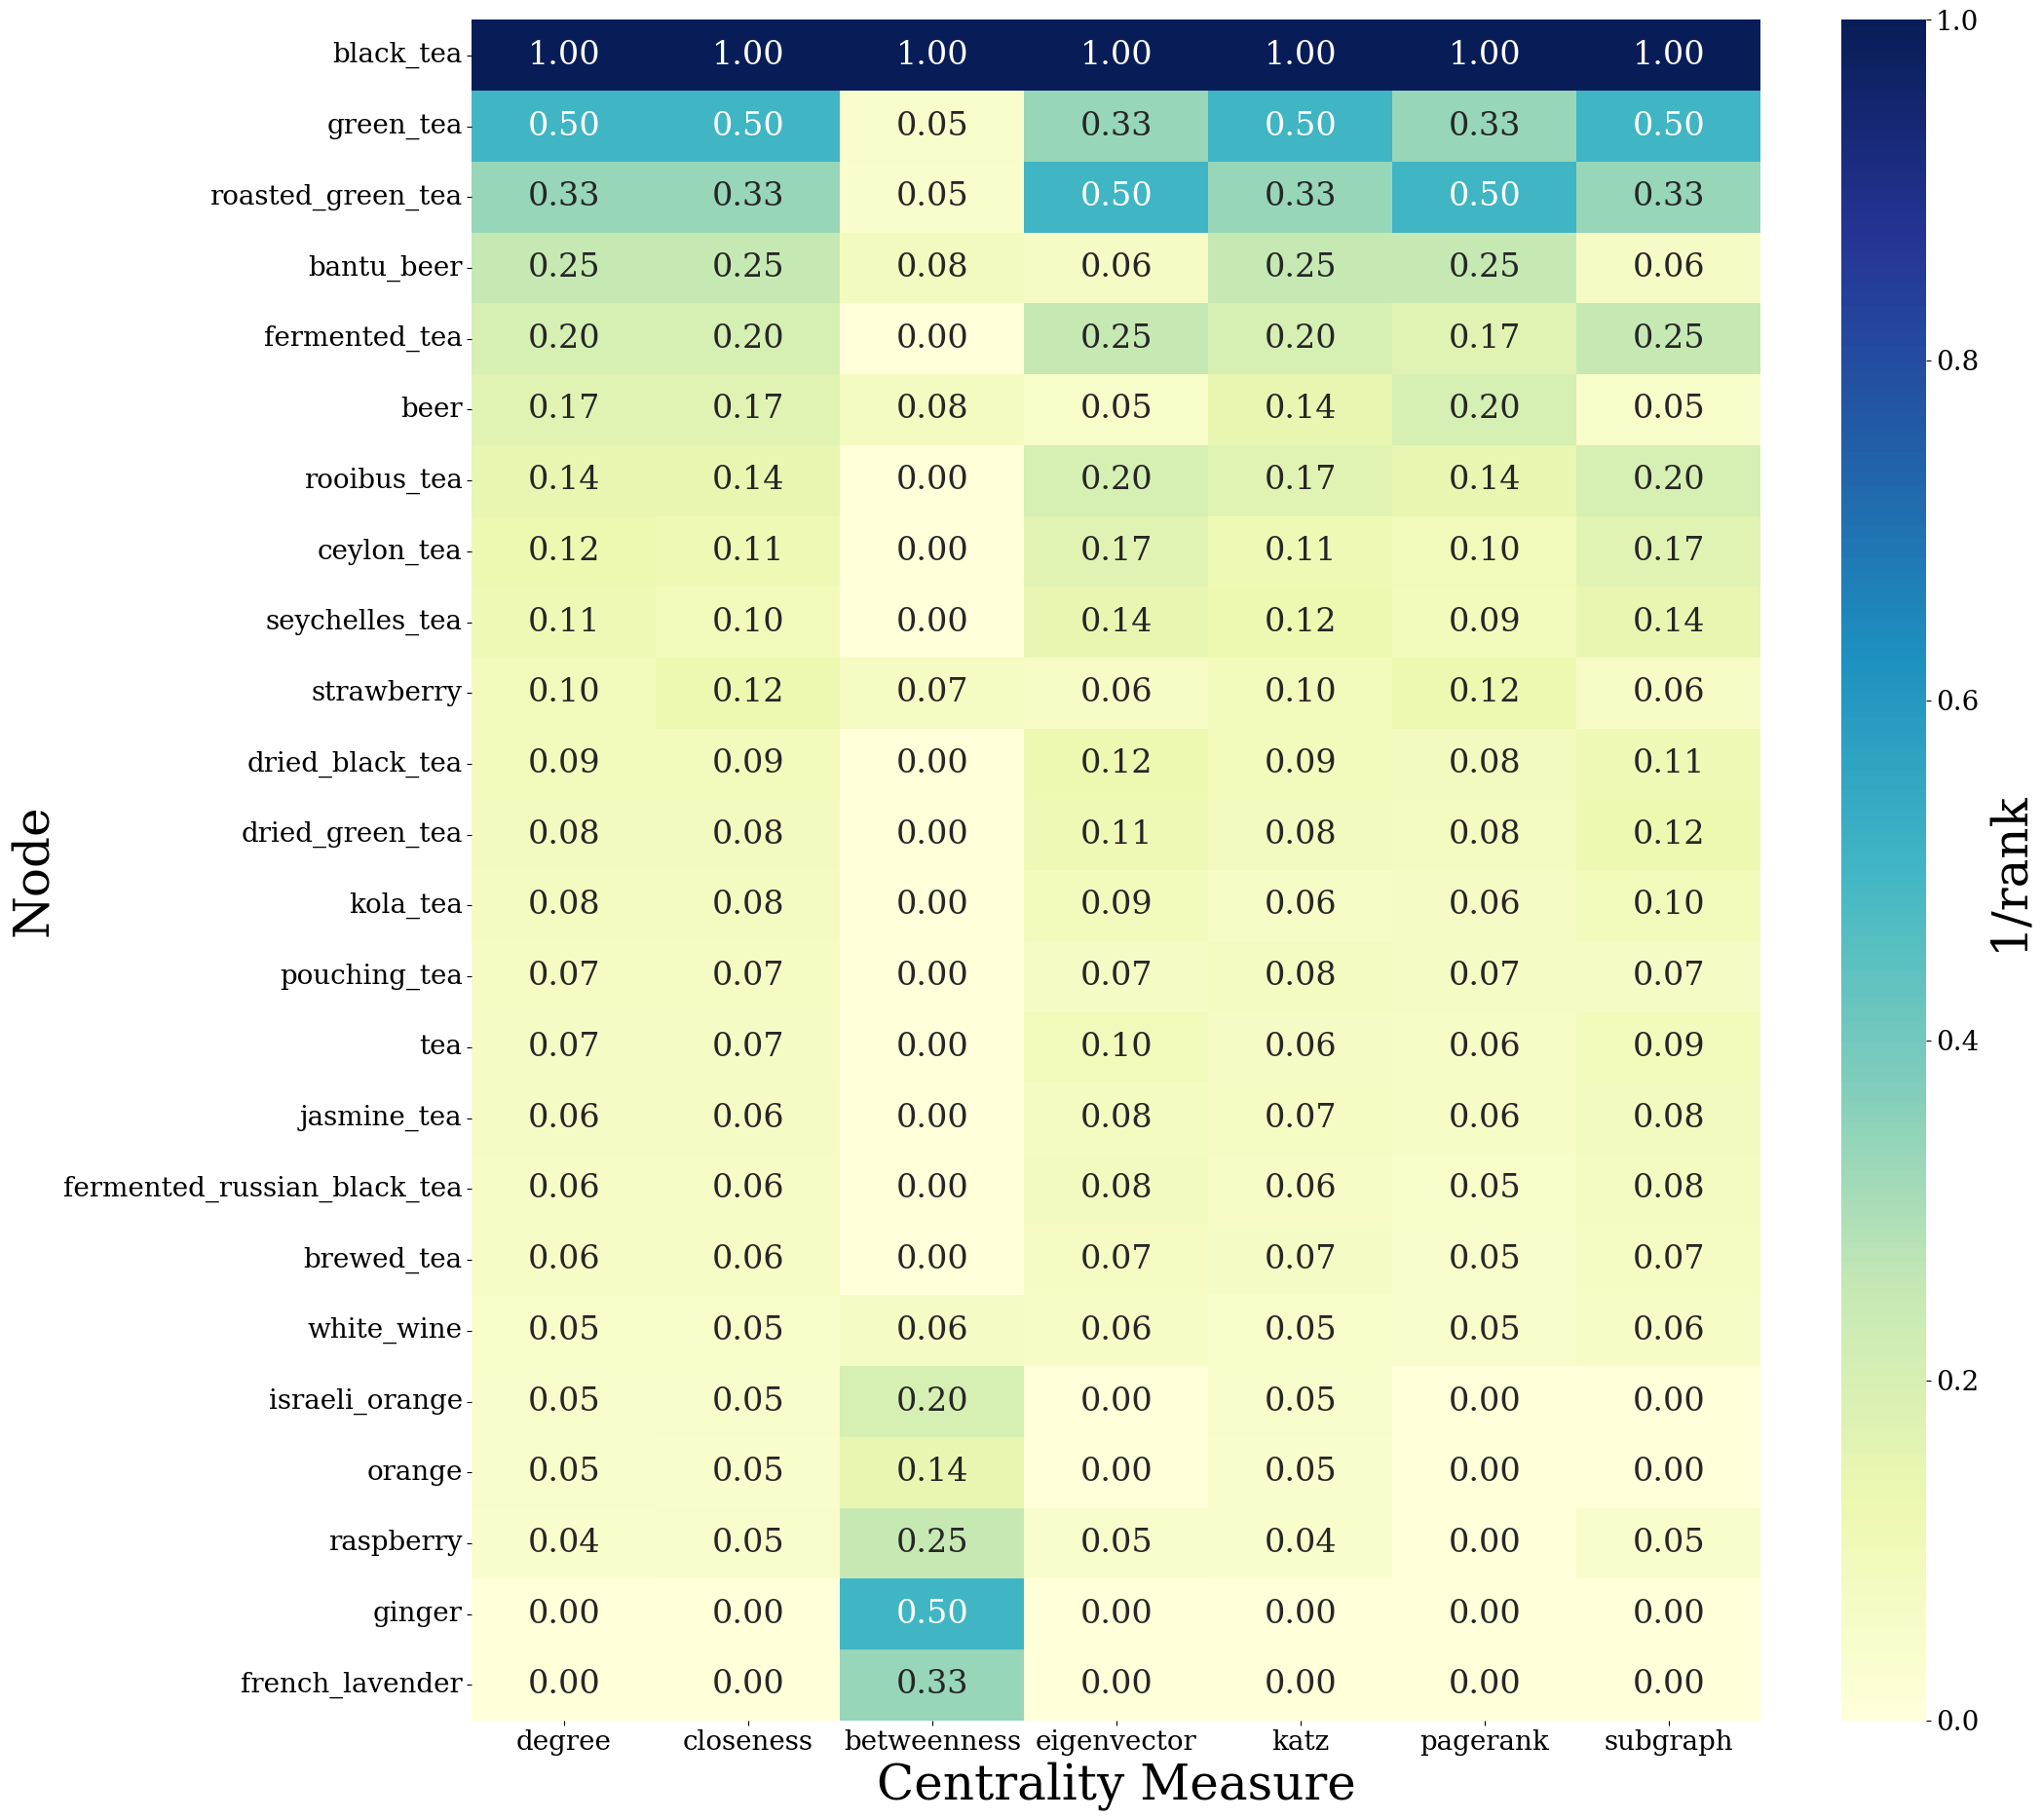

In [23]:
# Filter nodes with combined score >= 0.28
threshold = 7 / 25  # 0.28
filtered_nodes = [node for node, score in centrality_scores.items() if score >= threshold]

heatmap_data = pd.DataFrame(index=filtered_nodes, columns=centralities.keys())

for cname, cent_dict in centralities.items():
    # Top 25 nodes for this centrality
    top25 = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:25]
    for rank, (node, value) in enumerate(top25, start=1):
        if node in filtered_nodes:
            heatmap_data.loc[node, cname] = 1.0 / rank

# Fill missing values with 0 (nodes not in top 25 for a centrality)
heatmap_data = heatmap_data.fillna(0)

heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(22, len(filtered_nodes) * 0.8))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': '1/rank'}
)

cbar = ax.collections[0].colorbar
cbar.set_label('1/rank', fontsize=36)
# plt.title("Node Centrality Heatmap (Filtered by Combined Centrality Score >= 0.28)")
plt.xlabel("Centrality Measure", fontsize = 36)
plt.ylabel("Node", fontsize = 36)
plt.tight_layout()
plt.savefig("top_25_centrality.pdf")
plt.show()


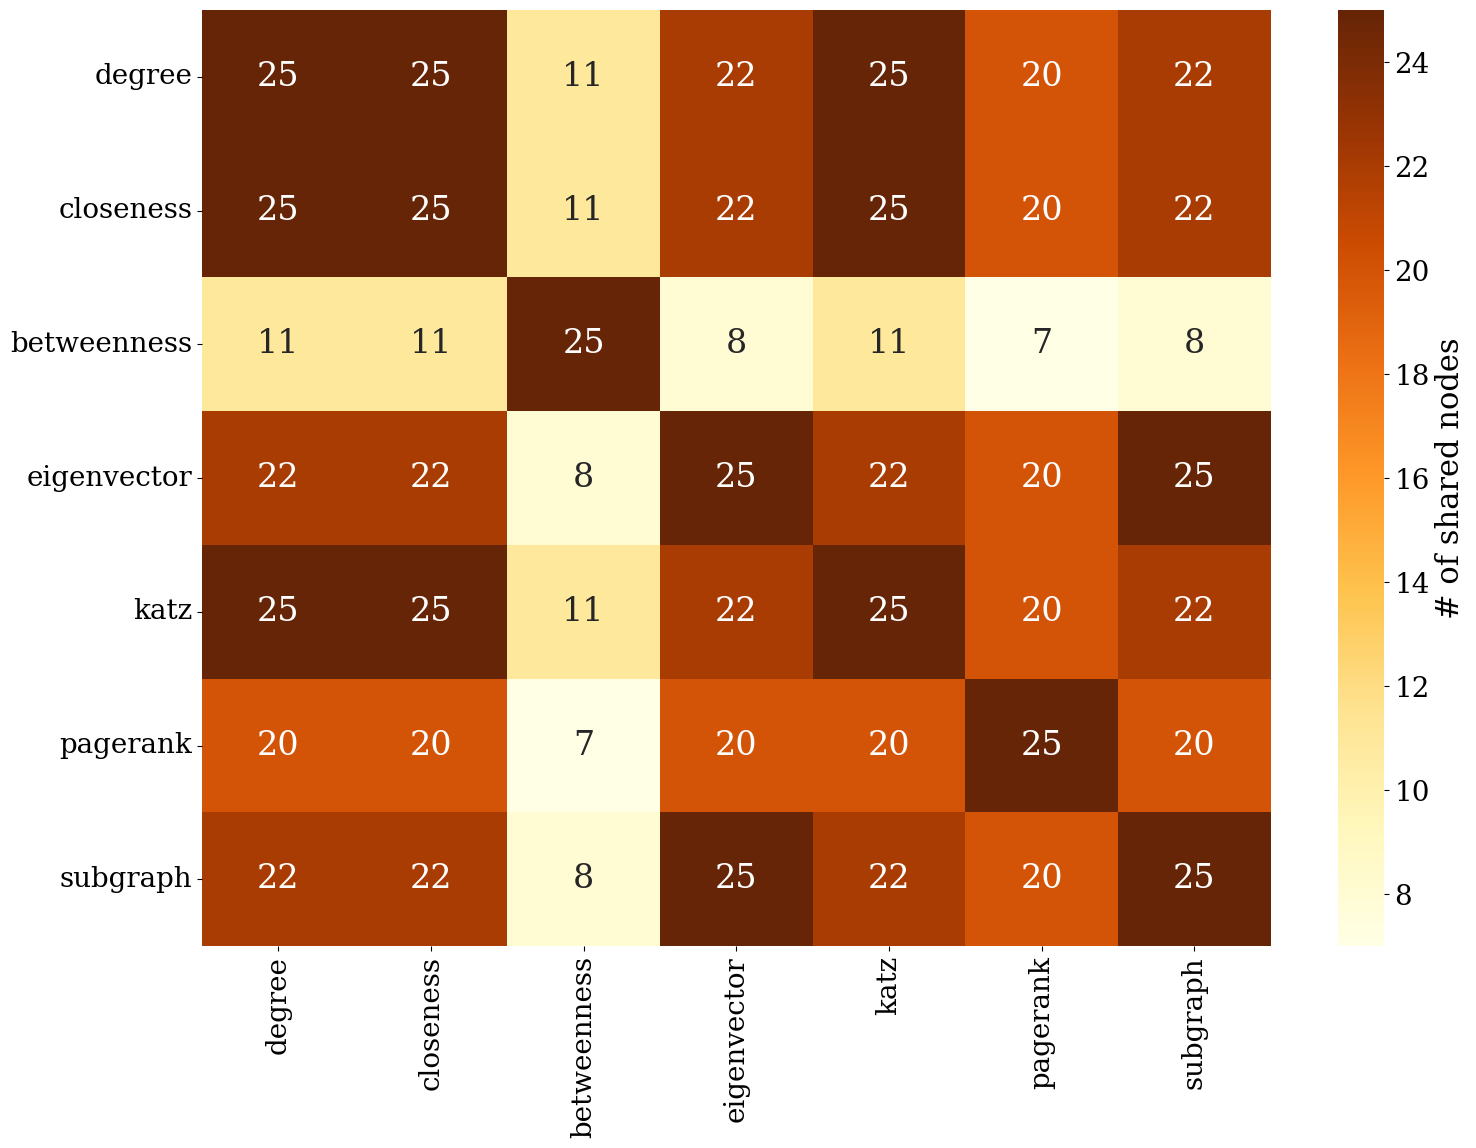

In [24]:
centrality_names = list(top25_nodes.keys())
n_centralities = len(centrality_names)

co_occurrence = np.zeros((n_centralities, n_centralities), dtype=int)

for i, ci in enumerate(centrality_names):
    for j, cj in enumerate(centrality_names):
        co_occurrence[i, j] = len(
            set(top25_nodes[ci]) & set(top25_nodes[cj])
        )

co_occurrence_df = pd.DataFrame(
    co_occurrence,
    index=centrality_names,
    columns=centrality_names
)

plt.figure(figsize=(16,12))
sns.heatmap(
    co_occurrence_df,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    cbar_kws={'label': '# of shared nodes'}
)
plt.tight_layout()
plt.savefig("Pairwise_comparison.pdf")
plt.show()

# Null models

In [25]:
# Null models we mean ER and BA

start_time = time.time()

def analyze_null_model(G_null):
    # Centralities
    raw_subgraph = nx.subgraph_centrality(G_null)

    adj = nx.to_scipy_sparse_array(G_null, dtype=float)
    lambda_max = linalg.eigsh(adj, k=1, which='LM', return_eigenvectors=False)[0]
    safe_alpha = 0.5 / lambda_max

    centralities = {
        "degree": dict(G_null.degree()),
        "closeness": nx.closeness_centrality(G_null),
        "betweenness": nx.betweenness_centrality(G_null),
        "eigenvector": nx.eigenvector_centrality_numpy(G_null),
        "katz": nx.katz_centrality_numpy(G_null, alpha=safe_alpha, beta=1.0),
        "pagerank": nx.pagerank(G_null),
        "subgraph": {n: np.log(v) for n, v in raw_subgraph.items()}
    }

    # Centrality summary statistics
    centrality_summary = {}
    for name, cent in centralities.items():
        values = np.array(list(cent.values()))
        centrality_summary[name + "_mean"] = values.mean()
        centrality_summary[name + "_std"] = values.std()
        centrality_summary[name + "_min"] = values.min()
        centrality_summary[name + "_max"] = values.max()

    # Path-based metrics
    lengths = []
    for source, dist_dict in nx.all_pairs_shortest_path_length(G_null):
        for target, dist in dist_dict.items():
            if source != target:
                lengths.append(dist)
    
    effective_diameter = np.percentile(lengths, 90)

    # Network metrics
    centrality_summary.update({
        "clustering": nx.average_clustering(G_null),
        "path_length": nx.average_shortest_path_length(G_null),
        "effective_diameter": effective_diameter,
        "degree_mean": np.mean([d for _, d in G_null.degree()]),
        "degree_distribution": [d for _, d in G_null.degree()]
    })

    return centrality_summary

In [26]:
ER_results = []
BA_results = []
CM_results = []

for i in range(10):
    seed_i = SEED + 2*i
    # Erdős-Rényi
    ER = nx.gnm_random_graph(N, E, seed=seed_i)
    ER_results.append(analyze_null_model(ER))
    
    # Barabási-Albert
    BA = nx.barabasi_albert_graph(N, m=round(E / N), seed=seed_i)
    BA_results.append(analyze_null_model(BA))
    
    # Configuration Model
    # Use the degree sequence of the empirical network
    CM = nx.configuration_model(list(dict(G.degree()).values()), seed=seed_i)
    # configuration_model returns a multigraph so convert to simple graph
    CM = nx.Graph(CM)  # merge parallel edges
    CM.remove_edges_from(nx.selfloop_edges(CM))  # remove self-loops
    CM_results.append(analyze_null_model(CM))

# Function to summarize across runs
def summarize(results, key):
    values = np.array([r[key] for r in results])
    return values.mean(), values.std(), values.min(), values.max()

print("\nNull model comparison (summary statistics):")
centrality_keys = [k for k in ER_results[0].keys() if k != "degree_distribution"]

for key in centrality_keys:
    er_mean, er_std, er_min, er_max = summarize(ER_results, key)
    ba_mean, ba_std, ba_min, ba_max = summarize(BA_results, key)
    cm_mean, cm_std, cm_min, cm_max = summarize(CM_results, key)
    
    print(f"\n{key}:")
    print(f"ER  mean ± std: {er_mean:.4f} ± {er_std:.4f}, min: {er_min:.4f}, max: {er_max:.4f}")
    print(f"BA  mean ± std: {ba_mean:.4f} ± {ba_std:.4f}, min: {ba_min:.4f}, max: {ba_max:.4f}")
    print(f"CM  mean ± std: {cm_mean:.4f} ± {cm_std:.4f}, min: {cm_min:.4f}, max: {cm_max:.4f}")

# Extract degree distributions for plotting later
ER_degree_distributions = [r["degree_distribution"] for r in ER_results]
BA_degree_distributions = [r["degree_distribution"] for r in BA_results]
CM_degree_distributions = [r["degree_distribution"] for r in CM_results]

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTime taken: {elapsed:.2f} seconds")


Null model comparison (summary statistics):

degree_mean:
ER  mean ± std: 296.4626 ± 0.0000, min: 296.4626, max: 296.4626
BA  mean ± std: 266.7166 ± 0.0000, min: 266.7166, max: 266.7166
CM  mean ± std: 215.9495 ± 0.1059, min: 215.7567, max: 216.1083

degree_std:
ER  mean ± std: 15.2333 ± 0.2733, min: 14.6981, max: 15.6498
BA  mean ± std: 128.7861 ± 0.5290, min: 127.8478, max: 129.4228
CM  mean ± std: 184.0345 ± 0.1183, min: 183.7272, max: 184.2007

degree_min:
ER  mean ± std: 246.7000 ± 2.5318, min: 241.0000, max: 250.0000
BA  mean ± std: 148.0000 ± 0.0000, min: 148.0000, max: 148.0000
CM  mean ± std: 1.0000 ± 0.0000, min: 1.0000, max: 1.0000

degree_max:
ER  mean ± std: 349.1000 ± 3.3897, min: 344.0000, max: 356.0000
BA  mean ± std: 778.2000 ± 12.1967, min: 765.0000, max: 808.0000
CM  mean ± std: 588.4000 ± 6.4062, min: 582.0000, max: 603.0000

closeness_mean:
ER  mean ± std: 0.5550 ± 0.0000, min: 0.5550, max: 0.5551
BA  mean ± std: 0.5503 ± 0.0000, min: 0.5503, max: 0.5503
CM  mean 

In [27]:
def format_null_stats(results, key, decimals=4):
    """
    Extracts the mean and standard deviation from the 10 runs.
    """
    values = np.array([r[key] for r in results], dtype=float)
    return f"{np.mean(values):.{decimals}f} ± {np.std(values):.{decimals}f}"

def format_real_mean(values, decimals=4):
    """
    Calculates the mean of the real network's centrality values.
    """
    if isinstance(values, (dict, list)):
        if isinstance(values, dict):
            values = list(values.values())
        return f"{np.mean(values):.{decimals}f}"
    return f"{values:.{decimals}f}"

In [28]:
# We will be comparing in log values as they are too big raw.
centralities["subgraph"] = {
    n: np.log(v) for n, v in centralities["subgraph"].items()
}

real_summary = {}

# Basic metrics
real_summary["degree_mean"] = mean_degree
real_summary["clustering"] = avg_clustering
real_summary["path_length"] = avg_path_length
real_summary["effective_diameter"] = effective_diameter

# Centralities (means)
real_summary["closeness_mean"] = np.mean(list(centralities["closeness"].values()))
real_summary["betweenness_mean"] = np.mean(list(centralities["betweenness"].values()))
real_summary["eigenvector_mean"] = np.mean(list(centralities["eigenvector"].values()))
real_summary["katz_mean"] = np.mean(list(centralities["katz"].values()))
real_summary["pagerank_mean"] = np.mean(list(centralities["pagerank"].values()))
real_summary["subgraph_mean"] = np.mean(np.array(list(centralities["subgraph"].values())))


In [29]:
rows = []

# Global Metrics
rows.append({
    "Metric": "Mean degree",
    "Real network": format_real_mean(real_summary["degree_mean"]),
    "Erdős–Rényi": format_null_stats(ER_results, "degree_mean"),
    "Barabási–Albert": format_null_stats(BA_results, "degree_mean"),
    "Configuration Model": format_null_stats(CM_results, "degree_mean"),
})

rows.append({
    "Metric": "Avg. clustering",
    "Real network": format_real_mean(real_summary["clustering"]),
    "Erdős–Rényi": format_null_stats(ER_results, "clustering"),
    "Barabási–Albert": format_null_stats(BA_results, "clustering"),
    "Configuration Model": format_null_stats(CM_results, "clustering"),
})

rows.append({
    "Metric": "Avg. path length",
    "Real network": format_real_mean(real_summary["path_length"]),
    "Erdős–Rényi": format_null_stats(ER_results, "path_length"),
    "Barabási–Albert": format_null_stats(BA_results, "path_length"),
    "Configuration Model": format_null_stats(CM_results, "path_length"),
})

# Centrality Metrics (Comparing Mean to Mean)
centrality_keys = [
    ("Closeness", "closeness"),
    ("Betweenness", "betweenness"),
    ("Eigenvector", "eigenvector"),
    ("Katz", "katz"),
    ("PageRank", "pagerank"),
    ("Subgraph (log)", "subgraph")
]

for label, key in centrality_keys:
    rows.append({
        "Metric": f"{label} (Mean)",
        "Real network": format_real_mean(centralities[key]),
        "Erdős–Rényi": format_null_stats(ER_results, f"{key}_mean"),
        "Barabási–Albert": format_null_stats(BA_results, f"{key}_mean"),
        "Configuration Model": format_null_stats(CM_results, f"{key}_mean"),
    })

# View the Result
summary_df = pd.DataFrame(rows).set_index("Metric")
print("\nFINAL SUMMARY TABLE (Mean ± Std):\n")
print(summary_df)



FINAL SUMMARY TABLE (Mean ± Std):

                      Real network        Erdős–Rényi    Barabási–Albert  \
Metric                                                                     
Mean degree               296.4626  296.4626 ± 0.0000  266.7166 ± 0.0000   
Avg. clustering             0.8581    0.1983 ± 0.0001    0.2685 ± 0.0010   
Avg. path length            1.9205    1.8017 ± 0.0000    1.8216 ± 0.0000   
Closeness (Mean)            0.5348    0.5550 ± 0.0000    0.5503 ± 0.0000   
Betweenness (Mean)          0.0006    0.0005 ± 0.0000    0.0005 ± 0.0000   
Eigenvector (Mean)          0.0193    0.0258 ± 0.0000    0.0233 ± 0.0000   
Katz (Mean)                 0.0259    0.0258 ± 0.0000    0.0253 ± 0.0000   
PageRank (Mean)             0.0007    0.0007 ± 0.0000    0.0007 ± 0.0000   
Subgraph (log) (Mean)     538.4549  289.9314 ± 0.0281  321.0089 ± 0.3448   

                      Configuration Model  
Metric                                     
Mean degree             215.9495 ± 0.10

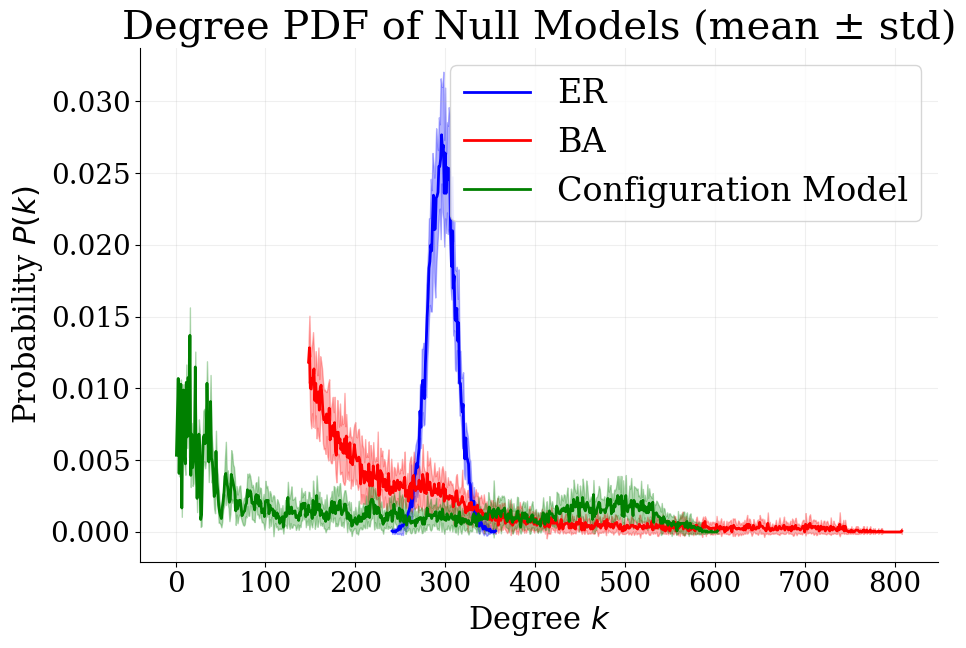

In [30]:
# Plot degree PDF (normal scale)
def plot_degree_pdf(degree_lists, label, color):
    max_k = max(max(lst) for lst in degree_lists)
    counts = np.zeros((len(degree_lists), max_k + 1))
    
    for i, degs in enumerate(degree_lists):
        hist, _ = np.histogram(
            degs,
            bins=np.arange(max_k + 2),
            density=True
        )
        counts[i, :len(hist)] = hist
    
    mean_counts = counts.mean(axis=0)
    std_counts = counts.std(axis=0)
    
    ks = np.arange(len(mean_counts))
    
    nonzero_idx = np.argmax(mean_counts > 0)
    
    ks = ks[nonzero_idx:]
    mean_counts = mean_counts[nonzero_idx:]
    std_counts = std_counts[nonzero_idx:]
    
    plt.fill_between(
        ks,
        mean_counts - std_counts,
        mean_counts + std_counts,
        color=color,
        alpha=0.3
    )
    plt.plot(ks, mean_counts, color=color, lw=2, label=label)


plt.figure(figsize=(10, 7))

plot_degree_pdf(ER_degree_distributions, "ER", "blue")
plot_degree_pdf(BA_degree_distributions, "BA", "red")
plot_degree_pdf(CM_degree_distributions, "Configuration Model", "green") 

plt.xlabel("Degree $k$")
plt.ylabel("Probability $P(k)$")
plt.title("Degree PDF of Null Models (mean ± std)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


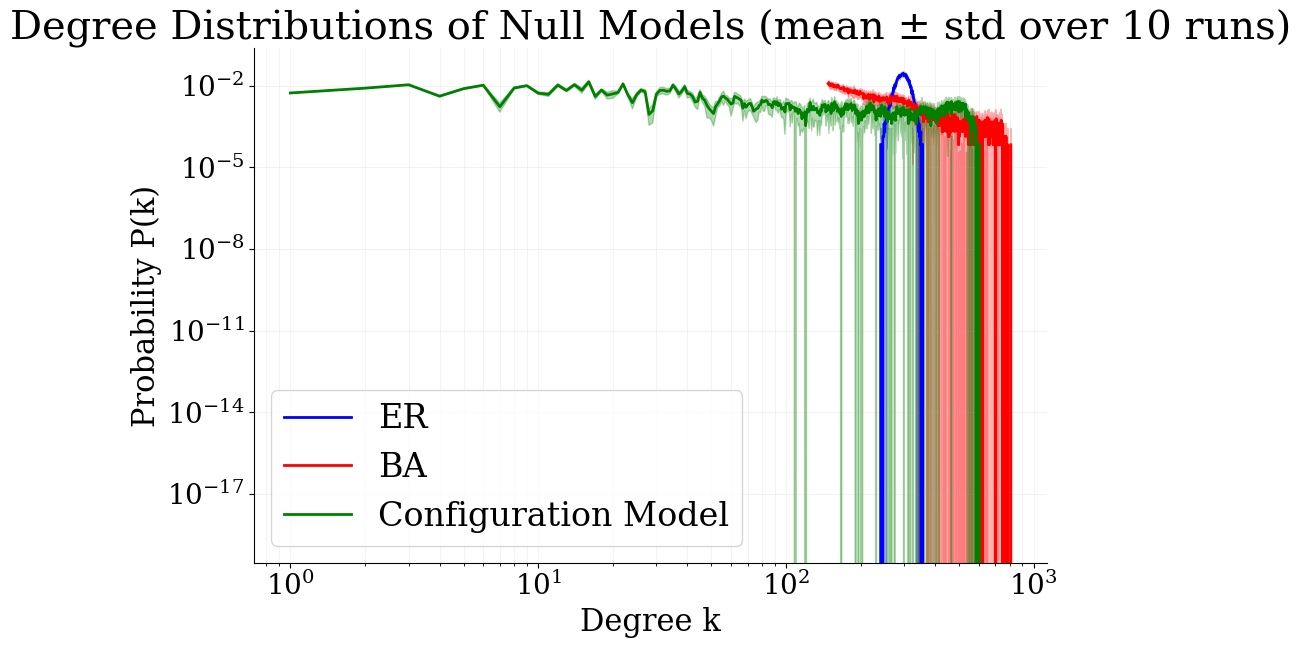

In [31]:
plt.figure(figsize=(10, 7))

plot_degree_pdf(ER_degree_distributions, "ER", "blue")
plot_degree_pdf(BA_degree_distributions, "BA", "red")
plot_degree_pdf(CM_degree_distributions, "Configuration Model", "green") 

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree k")
plt.ylabel("Probability P(k)")
plt.title("Degree Distributions of Null Models (mean ± std over 10 runs)")
plt.legend()
plt.grid(True, which="both", alpha=0.15)
plt.tight_layout()
plt.show()

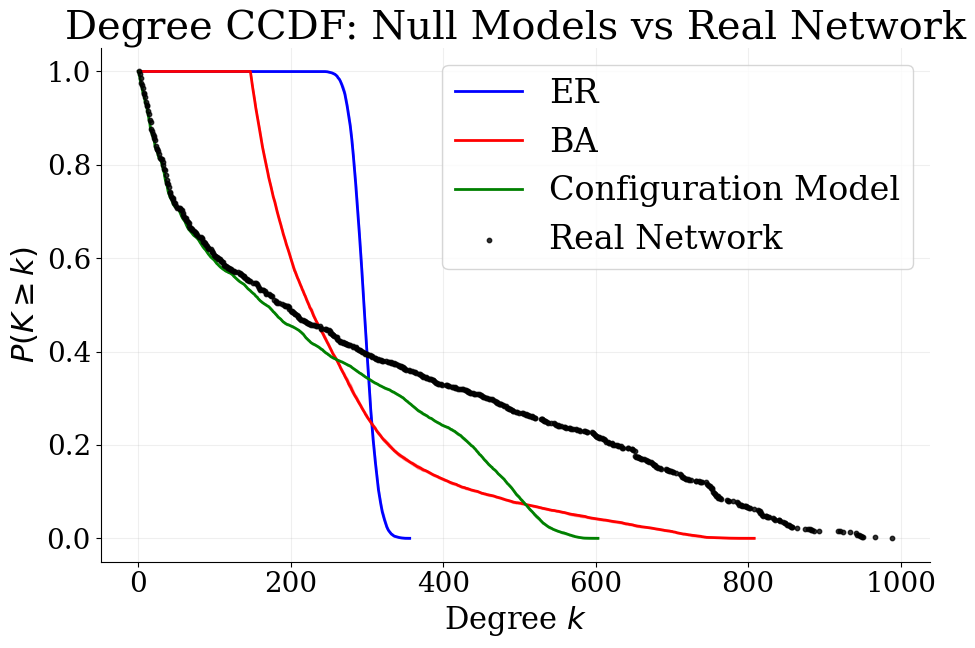

In [32]:
# Plot degree CCDF (normal scale)
def plot_degree_ccdf(degree_lists, label, color):
    max_k = max(max(lst) for lst in degree_lists)
    ccdfs = np.zeros((len(degree_lists), max_k + 1))
    
    for i, degs in enumerate(degree_lists):
        hist, _ = np.histogram(
            degs,
            bins=np.arange(max_k + 2),
            density=True
        )
        ccdf = 1.0 - np.cumsum(hist)
        ccdfs[i, :len(ccdf)] = ccdf
    
    mean_ccdf = ccdfs.mean(axis=0)
    std_ccdf = ccdfs.std(axis=0)
    
    ks = np.arange(len(mean_ccdf))
    
    plt.fill_between(
        ks,
        mean_ccdf - std_ccdf,
        mean_ccdf + std_ccdf,
        color=color,
        alpha=0.3
    )
    plt.plot(ks, mean_ccdf, color=color, lw=2, label=label)


plt.figure(figsize=(10, 7))

# Null models
plot_degree_ccdf(ER_degree_distributions, "ER", "blue")
plot_degree_ccdf(BA_degree_distributions, "BA", "red")
plot_degree_ccdf(CM_degree_distributions, "Configuration Model", "green") 

# Real network as scatter
plt.scatter(
    k_vals,
    ccdf,
    color="black",
    s=10,
    alpha=0.8,
    label="Real Network",
    zorder=10
)

plt.xlabel("Degree $k$")
plt.ylabel(r"$P(K \geq k)$")
plt.title("Degree CCDF: Null Models vs Real Network")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

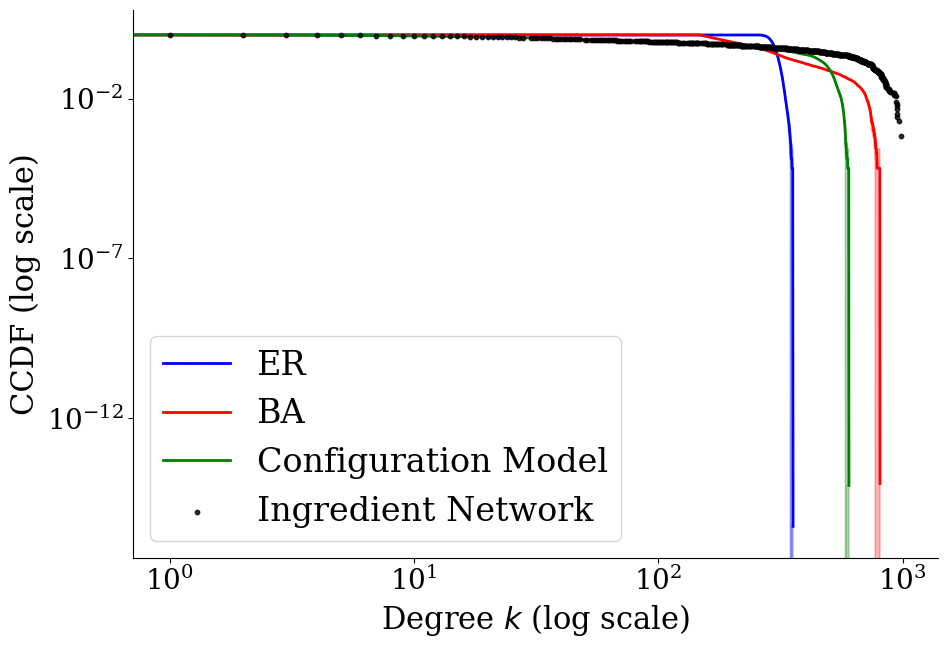

In [33]:


plt.figure(figsize=(10, 7))

# Null models
plot_degree_ccdf(ER_degree_distributions, "ER", "blue")
plot_degree_ccdf(BA_degree_distributions, "BA", "red")
plot_degree_ccdf(CM_degree_distributions, "Configuration Model", "green")

# Real network
plt.scatter(
    k_vals,
    ccdf,
    color="black",
    s=10,
    alpha=0.8,
    label="Ingredient Network",
    zorder=10
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Degree $k$ (log scale)")
plt.ylabel(r"CCDF (log scale)")
plt.legend()
plt.grid(False)

# limit ticks
ax = plt.gca()

ax.xaxis.set_major_locator(ticker.LogLocator(numticks=4))
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=4))

ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig("null_models_CCDF.pdf")
plt.show()


# Community detection

In [34]:
start_time = time.time()

community_results = {}

# 1. Greedy Modularity
greedy_partition = list(greedy_modularity_communities(G))
cov, perf = nx.algorithms.community.partition_quality(G, greedy_partition)
community_results["Greedy Modularity"] = {
    "partition": greedy_partition,
    "modularity": modularity(G, greedy_partition),
    "coverage": cov,
    "performance": perf,
    "num_communities": len(greedy_partition)
}

# 2. Louvain
louvain_partition_dict = community_louvain.best_partition(G, random_state=SEED)

louvain_partition = []
for com in set(louvain_partition_dict.values()):
    louvain_partition.append({node for node, c in louvain_partition_dict.items() if c == com})

cov, perf = nx.algorithms.community.partition_quality(G, louvain_partition)

community_results["Louvain"] = {
    "partition": louvain_partition,
    "modularity": community_louvain.modularity(louvain_partition_dict, G),
    "coverage": cov,
    "performance": perf,
    "num_communities": len(louvain_partition)
}

# 3. Label Propagation
lp_partition = list(label_propagation_communities(G))
cov, perf = nx.algorithms.community.partition_quality(G, lp_partition)
community_results["Label Propagation"] = {
    "partition": lp_partition,
    "modularity": modularity(G, lp_partition),
    "coverage": cov,
    "performance": perf,
    "num_communities": len(lp_partition)
}



In [35]:
# Print comparison table
print(f"{'Method':25s} {'# Communities':>15s} {'Modularity':>12s} {'Coverage':>10s} {'Performance':>12s}")
print("-"*75)
for method, res in community_results.items():
    print(f"{method:25s} {res['num_communities']:15d} {res['modularity']:12.4f} {res['coverage']:10.4f} {res['performance']:12.4f}")

end_time = time.time()
elapsed = end_time - start_time
print(f"Time taken: {elapsed:.2f} seconds")

Method                      # Communities   Modularity   Coverage  Performance
---------------------------------------------------------------------------
Greedy Modularity                       7       0.0957     0.6031       0.6085
Louvain                                 5       0.1199     0.4562       0.6171
Label Propagation                       7       0.0002     0.9991       0.2441
Time taken: 39.46 seconds


In [36]:
start_time = time.time()


def analyze_null_communities(G_null):
    # 1. Greedy Modularity
    greedy_p = list(greedy_modularity_communities(G_null))
    greedy_cov, greedy_perf = partition_quality(G_null, greedy_p)
    
    # 2. Louvain
    louvain_p_dict = community_louvain.best_partition(G_null, random_state=SEED)
    louvain_p = []
    for com in set(louvain_p_dict.values()):
        louvain_p.append({node for node, c in louvain_p_dict.items() if c == com})
    louvain_cov, louvain_perf = partition_quality(G_null, louvain_p)
    
    # 3. Label Propagation
    lp_p = list(label_propagation_communities(G_null))
    lp_cov, lp_perf = partition_quality(G_null, lp_p)
    
    return {
        "greedy_mod": modularity(G_null, greedy_p),
        "greedy_cov": greedy_cov,
        "greedy_perf": greedy_perf,
        "greedy_count": len(greedy_p),
        
        "louvain_mod": community_louvain.modularity(louvain_p_dict, G_null),
        "louvain_cov": louvain_cov,
        "louvain_perf": louvain_perf,
        "louvain_count": len(louvain_p),
        
        "lp_mod": modularity(G_null, lp_p),
        "lp_cov": lp_cov,
        "lp_perf": lp_perf,
        "lp_count": len(lp_p)
    }

# Containers
ER_comm_results = []
BA_comm_results = []
CFG_comm_results = []

print("Running Community Detection on Null Models (this may take a moment)...")
for i in range(10):
    # --- ER ---
    ER = nx.gnm_random_graph(N, E, seed=SEED + 2*i)
    ER_comm_results.append(analyze_null_communities(ER))
    
    # --- BA ---
    BA = nx.barabasi_albert_graph(N, m=round(E / N), seed=SEED + 2*i)
    BA_comm_results.append(analyze_null_communities(BA))
    
    # --- Configuration Model ---
    CFG = nx.configuration_model(list(degrees), seed=SEED + 2*i)
    # Convert to simple graph (remove parallel edges & self-loops)
    CFG = nx.Graph(CFG)  
    CFG.remove_edges_from(nx.selfloop_edges(CFG))
    CFG_comm_results.append(analyze_null_communities(CFG))

end_time = time.time()
elapsed = end_time - start_time
print(f"Time taken: {elapsed:.2f} seconds")


Running Community Detection on Null Models (this may take a moment)...
Time taken: 1349.67 seconds


In [37]:
def print_comm_table(title, data_source, is_ensemble=True):
    """
    Prints a formatted table for either null model ensembles or real network results,
    including standard deviation for all ensemble metrics.
    """
    print(f"\n--- {title} ---")
    header = f"{'Algorithm':20} {'Count':>14} {'Modularity':>18} {'Coverage':>18} {'Performance':>18}"
    print(header)
    print("-" * len(header))

    mapping = {
        "Greedy Modularity": "greedy",
        "Louvain": "louvain",
        "Label Propagation": "lp"
    }

    for display_name, internal_key in mapping.items():
        if is_ensemble:
            counts = [r[f"{internal_key}_count"] for r in data_source]
            mods   = [r[f"{internal_key}_mod"]   for r in data_source]
            covs   = [r[f"{internal_key}_cov"]   for r in data_source]
            perfs  = [r[f"{internal_key}_perf"]  for r in data_source]
            
            # Format ALL as Mean ± Std
            count_str = f"{np.mean(counts):.1f}±{np.std(counts):.1f}"
            mod_str   = f"{np.mean(mods):.4f}±{np.std(mods):.4f}"
            cov_str   = f"{np.mean(covs):.4f}±{np.std(covs):.4f}"
            perf_str  = f"{np.mean(perfs):.4f}±{np.std(perfs):.4f}"
        else:
            # Single run (Ingredient Network does not have multiple runs)
            res = data_source[display_name]
            count_str = f"{res['num_communities']}"
            mod_str   = f"{res['modularity']:.4f}"
            cov_str   = f"{res['coverage']:.4f}"
            perf_str  = f"{res['performance']:.4f}"

        print(f"{display_name:20} {count_str:>14} {mod_str:>18} {cov_str:>18} {perf_str:>18}")

print_comm_table("Ingredient Network Community Results", community_results, is_ensemble=False)

print_comm_table("ER Ensemble (Mean ± Std)", ER_comm_results, is_ensemble=True)

print_comm_table("BA Ensemble (Mean ± Std)", BA_comm_results, is_ensemble=True)

print_comm_table("CFG Ensemble (Mean ± Std)", CFG_comm_results, is_ensemble=True)


--- Ingredient Network Community Results ---
Algorithm                     Count         Modularity           Coverage        Performance
--------------------------------------------------------------------------------------------
Greedy Modularity                 7             0.0957             0.6031             0.6085
Louvain                           5             0.1199             0.4562             0.6171
Label Propagation                 7             0.0002             0.9991             0.2441

--- ER Ensemble (Mean ± Std) ---
Algorithm                     Count         Modularity           Coverage        Performance
--------------------------------------------------------------------------------------------
Greedy Modularity           3.0±0.0      0.0359±0.0005      0.4674±0.0126      0.5560±0.0080
Louvain                     8.1±0.7      0.0435±0.0006      0.1759±0.0081      0.7397±0.0043
Label Propagation           1.0±0.0      0.0000±0.0000      1.0000±0.0000      0.19

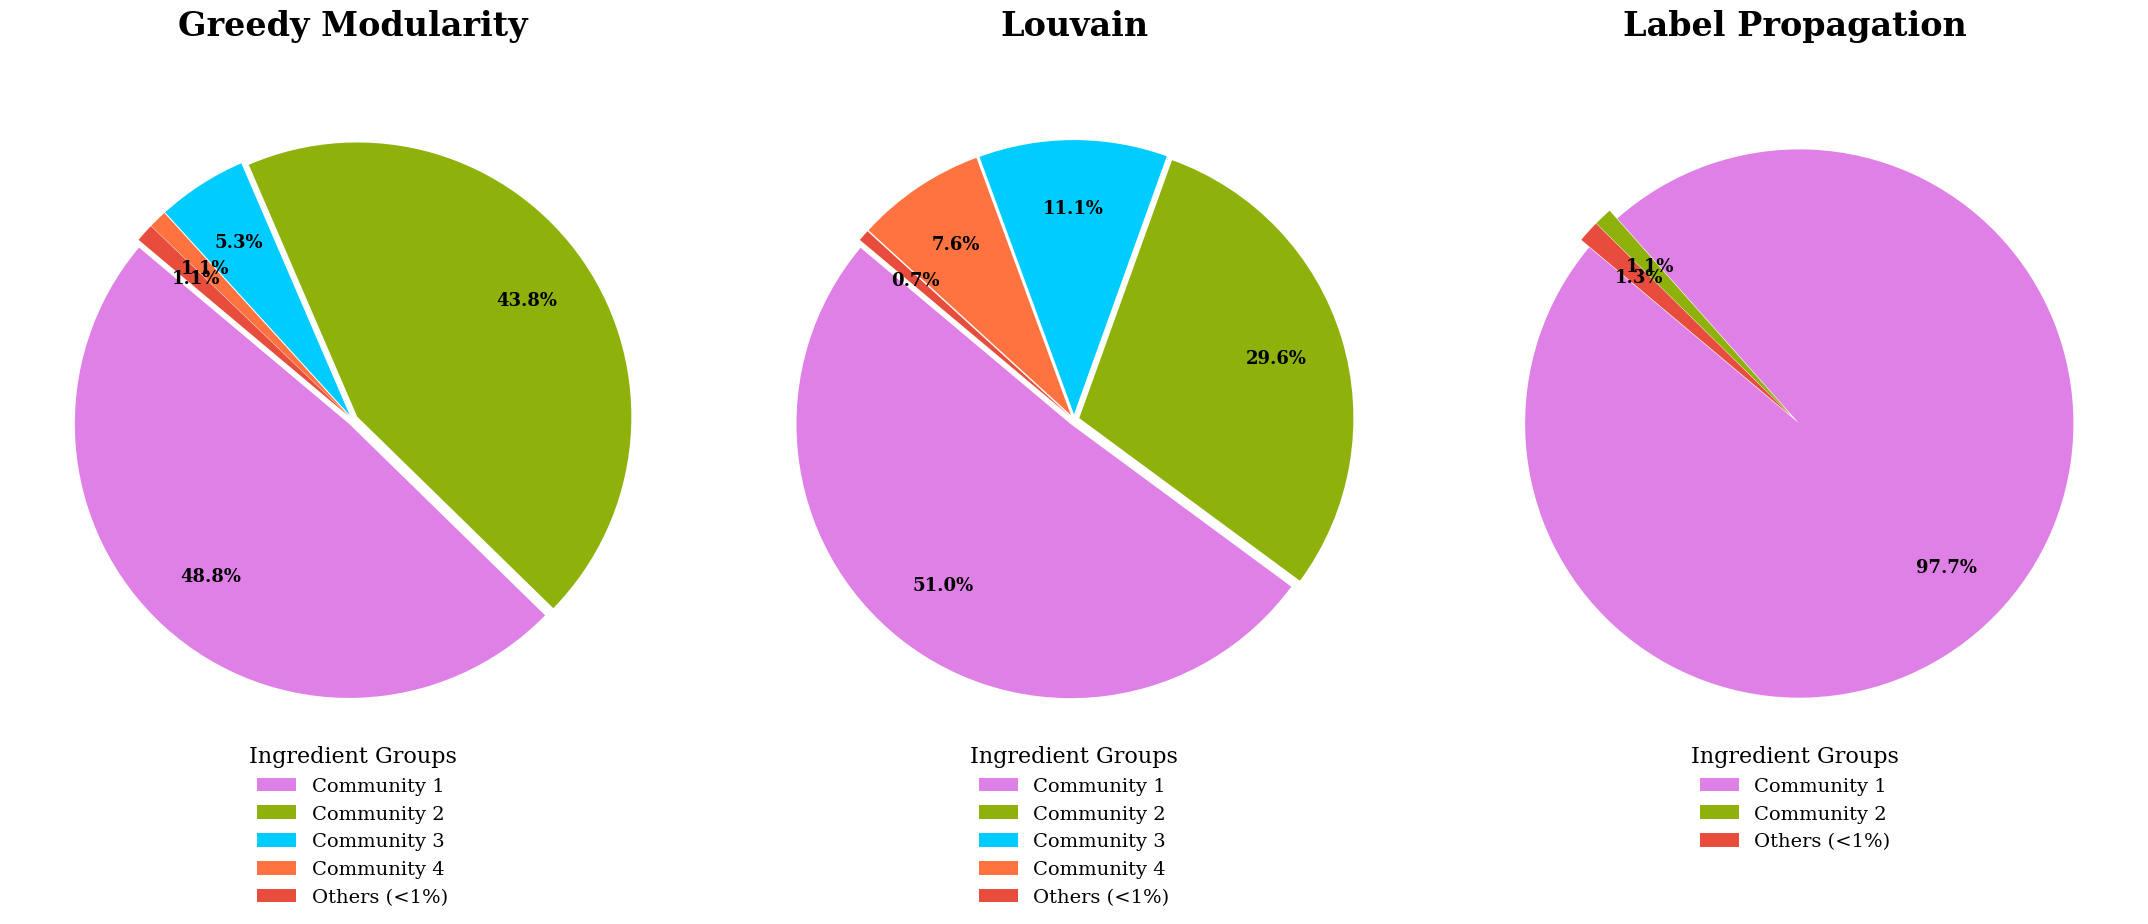

In [38]:
# We define the specific colors from the Gephi palette in order of group size
gephi_colors = [
    "#df80e6", # Pink
    "#8eb10b", # Green
    "#00ccff", # Light Blue
    "#ff7340", # Orange
    "#1e7d5d", # Dark Green
    "#e74c3c", # Red (Standard for 'Others' or extra communities)
]

methods = ["Greedy Modularity", "Louvain", "Label Propagation"]

fig, axes = plt.subplots(1, 3, figsize=(22, 10))

for i, method in enumerate(methods):
    # Get sizes and sort them largest to smallest 
    sizes = [len(c) for c in community_results[method]["partition"]]
    sizes.sort(reverse=True)
    
    # Filter for significant communities based on 1% threshold 
    threshold = 0.01 * N
    main_sizes = [s for s in sizes if s >= threshold]
    other_sum = sum(s for s in sizes if s < threshold)
    
    final_sizes = main_sizes
    labels = [f"Community {j+1}" for j in range(len(main_sizes))]
    
    if other_sum > 0:
        final_sizes.append(other_sum)
        labels.append("Others (<1%)")

    # Color Assignment
    current_colors = []
    for j, label in enumerate(labels):
        if "Others" in label:
            current_colors.append("#e74c3c") # We put red for "Others"
        else:
            # Map the rank to the Gephi color palette
            color_index = j % len(gephi_colors)
            current_colors.append(gephi_colors[color_index])

    wedges, texts, autotexts = axes[i].pie(
        final_sizes, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=current_colors,
        pctdistance=0.75,
        explode=[0.02] * len(final_sizes)
    )
    
    plt.setp(autotexts, size=13, weight="bold", color="black")
    axes[i].set_title(method, fontsize=24, pad=30, weight='bold')
    
    # Legend positioned at the bottom 
    axes[i].legend(
        wedges, 
        labels,
        title="Ingredient Groups",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        fontsize=14,
        title_fontsize=16,
        frameon=False
    )

plt.tight_layout()
plt.savefig("Ingredient_communities_circles.pdf")
plt.show()


# Visualization

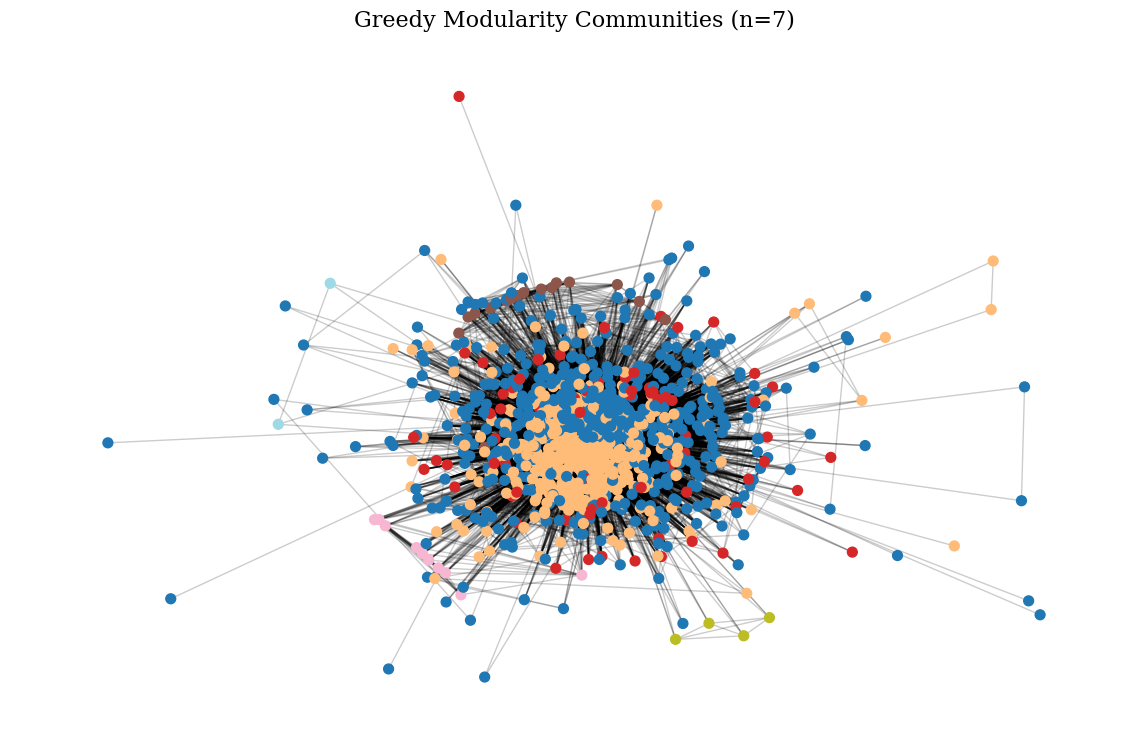

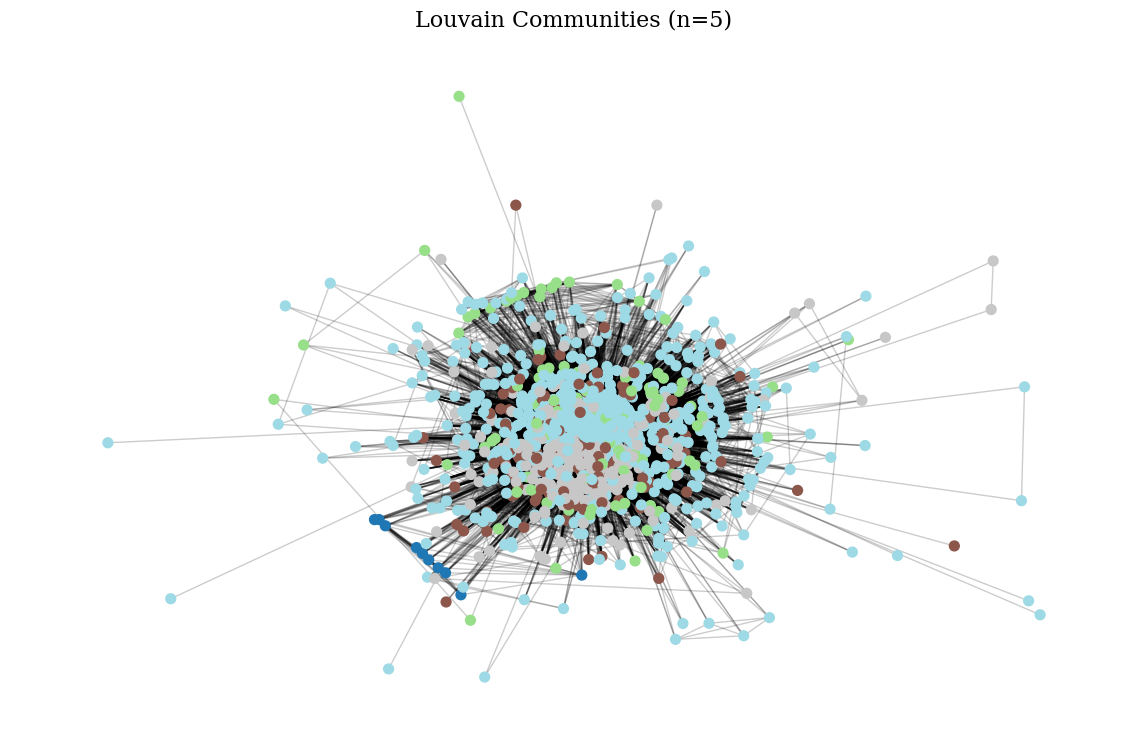

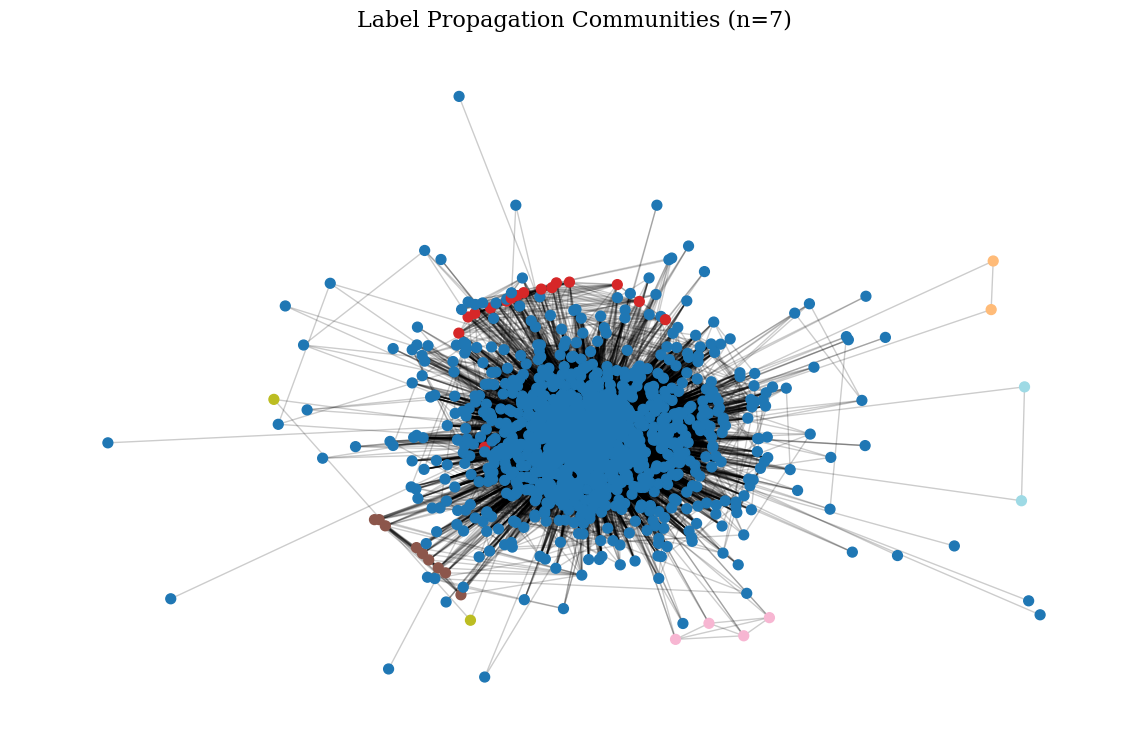

In [39]:
pos = nx.spring_layout(G, seed=SEED)

for method, res in community_results.items():
    # Assign colors to communities
    partitions = res['partition']
    node_color_map = {}
    for i, comm in enumerate(partitions):
        for node in comm:
            node_color_map[node] = i
    colors = [node_color_map[node] for node in G.nodes()]

    # Plot
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(f"{method} Communities (n={res['num_communities']})", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [40]:
# Export graph with communities for Gephi
for method, res in community_results.items():

    print(f"Processing community method: {method}")

    G_export = copy.deepcopy(G)

    # Build node with community mapping
    node_community = {}
    for i, comm in enumerate(res["partition"]):
        for node in comm:
            node_community[node] = i

    # Safety check: every node should have a community
    missing = set(G_export.nodes()) - set(node_community.keys())
    if missing:
        raise ValueError(
            f"Community assignment missing for {len(missing)} nodes "
            f"in method '{method}'"
        )

    # Attach community as a node attribute
    nx.set_node_attributes(G_export, node_community, "community")

    method_safe = method.replace(" ", "_").lower()

    # Export to GEXF (Gephi-native format)
    output_file = f"ing_network_{method_safe}.gexf"
    nx.write_gexf(G_export, output_file)

    print(f"Saved Gephi-ready graph: {output_file}")


Processing community method: Greedy Modularity
Saved Gephi-ready graph: ing_network_greedy_modularity.gexf
Processing community method: Louvain
Saved Gephi-ready graph: ing_network_louvain.gexf
Processing community method: Label Propagation
Saved Gephi-ready graph: ing_network_label_propagation.gexf
